# Data Imputation Pipeline

This notebook implements a hierarchical time-series imputation strategy for the Penn World Table dataset.

**Imputation Strategy:**
1. Log-linear interpolation (for positive values)
2. Linear interpolation (fallback)
3. Growth-rate extrapolation (for edges)
4. Constant fill (LOCF/BOCF)
5. Proxy-based substitution (for entirely missing series)

Each observation receives a flag indicating the imputation method used.

## 1. Setup

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

## 2. Load Cleaned Dataset

In [21]:
df = pd.read_csv('dataset/pwt110_cleaned.csv')
print(f"Loaded {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Countries: {df['countrycode'].nunique()}")
print(f"Year range: {df['year'].min()}-{df['year'].max()}")

Loaded 11,201 rows, 51 columns
Countries: 185
Year range: 1950-2023


## 3. Helper Functions

In [22]:
def imputation_summary_before(df, var):
    """Print summary of missing values before imputation."""
    total = len(df)
    missing = df[var].isna().sum()
    pct_missing = (missing / total) * 100
    print(f"\n{'='*60}")
    print(f"Variable: {var.upper()}")
    print(f"{'='*60}")
    print(f"Before imputation: {missing:,} missing values ({pct_missing:.2f}%)")


def imputation_summary_after(df, var):
    """Print detailed summary after imputation."""
    flag_col = f"i_{var}"
    if flag_col not in df.columns:
        print(f"[!] No flag column '{flag_col}' found")
        return

    total = len(df)
    
    # Map flag values to method names
    flag_labels = {
        0: "Original data",
        1: "Log-linear interpolation",
        2: "Linear interpolation",
        3: "Growth-rate extrapolation",
        4: "Constant fill (LOCF/BOCF)",
        5: "Proxy substitution"
    }
    
    summary = (
        df[flag_col]
        .value_counts()
        .reindex([0, 1, 2, 3, 4, 5], fill_value=0)
        .rename(index=flag_labels)
    )

    print(f"\nAfter imputation:")
    for label, count in summary.items():
        if count > 0:
            pct = (count / total) * 100
            print(f"  • {label:.<40} {count:>6,} ({pct:>5.2f}%)")

    # Check for remaining missing values
    remaining = df[var].isna().sum()
    if remaining > 0:
        pct = (remaining / total) * 100
        print(f"  [!] REMAINING MISSING: {remaining:,} ({pct:.2f}%)")
    else:
        print(f"  [OK] Complete (no missing values)")

## 4. Main Imputation Function

In [23]:
def impute_timeseries(df, var, group_col='countrycode', proxy_var=None, use_proxy=True):
    """
    Hierarchical imputation for time series data.

    Imputation flag meanings:
        0 = Original data
        1 = Log-linear interpolation
        2 = Linear interpolation
        3 = Growth-rate extrapolation (short edges)
        4 = Constant fill (LOCF/BOCF)
        5 = Proxy-based substitution (for completely missing series)

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    var : str
        Variable name to impute.
    group_col : str
        Grouping column (e.g., 'countrycode').
    proxy_var : str, optional
        Proxy variable for substitution of entirely missing series.
    use_proxy : bool, default True
        Whether to apply proxy substitution.

    Returns
    -------
    pd.DataFrame
        Dataset with imputed variable and flag column.
    """
    df = df.copy()
    flag_col = f"i_{var}"
    df[flag_col] = 0  # Initialize flag

    def _impute_group(g):
        """Apply hierarchical imputation to a single group."""
        x = g[var].copy()

        # (1) Log-linear interpolation
        try:
            mask = x.isna()
            if (x > 0).sum() > 1:  # Need at least 2 positive values
                log_x = np.log(x)
                log_interp = log_x.interpolate(method='linear', limit_direction='both')
                new_x = np.exp(log_interp)
                g.loc[mask & new_x.notna(), flag_col] = 1
                x = x.fillna(new_x)
        except Exception:
            pass

        # (2) Linear interpolation
        if x.isna().sum() > 0:
            lin_interp = x.interpolate(method='linear', limit_direction='both')
            newly_filled = x.isna() & lin_interp.notna()
            g.loc[newly_filled, flag_col] = 2
            x = x.fillna(lin_interp)

        # (3) Growth-rate extrapolation (for edge gaps)
        if x.isna().sum() > 0:
            valid = x.dropna()
            if len(valid) >= 2:
                avg_growth = valid.pct_change().mean()
                first_valid = x.first_valid_index()
                last_valid = x.last_valid_index()

                # Backward extrapolation
                if first_valid is not None:
                    before = x.loc[:first_valid].iloc[:-1]
                    for i in before.index[::-1]:
                        next_idx = x.index.get_loc(i) + 1
                        if next_idx < len(x):
                            next_val = x.iloc[next_idx]
                            if pd.notna(next_val):
                                x.loc[i] = next_val / (1 + avg_growth)
                                g.loc[i, flag_col] = 3

                # Forward extrapolation
                if last_valid is not None:
                    after = x.loc[last_valid:]
                    for i in after.index[1:]:
                        prev_idx = x.index.get_loc(i) - 1
                        if prev_idx >= 0:
                            prev_val = x.iloc[prev_idx]
                            if pd.notna(prev_val):
                                x.loc[i] = prev_val * (1 + avg_growth)
                                g.loc[i, flag_col] = 3

        # (4) Constant fill (LOCF/BOCF)
        if x.isna().sum() > 0:
            ffilled = x.ffill().bfill()
            newly_filled = x.isna() & ffilled.notna()
            g.loc[newly_filled, flag_col] = 4
            x = x.fillna(ffilled)

        g[var] = x
        return g

    # Apply imputation per group (FutureWarning suppressed at notebook level)
    df = df.groupby(group_col, group_keys=False).apply(_impute_group)

    # (5) Proxy-based substitution for entirely missing series
    if use_proxy and proxy_var is not None and proxy_var in df.columns:
        # Compute median ratio var/proxy_var where both exist
        ratio = (df[var] / df[proxy_var]).replace([np.inf, -np.inf], np.nan)
        median_ratio = ratio.median(skipna=True)

        # Only proceed if median ratio is meaningful
        if pd.notna(median_ratio) and median_ratio > 0:
            # Identify countries with no valid data
            missing_countries = (
                df.groupby(group_col)[var]
                .apply(lambda x: x.notna().sum() == 0)
            )
            missing_countries = missing_countries[missing_countries].index.tolist()

            if missing_countries:
                print(f"  → Proxy substitution: {len(missing_countries)} countries using {proxy_var} (median ratio: {median_ratio:.3f})")

                for c in missing_countries:
                    mask = df[group_col] == c
                    df.loc[mask, var] = df.loc[mask, proxy_var] * median_ratio
                    df.loc[mask, flag_col] = 5
        else:
            print(f"  → Proxy substitution skipped: invalid median ratio ({median_ratio})")

    return df

## 5. Execute Imputation

We impute the following variables with different strategies:
- **emp**: Employment (interpolation only)
- **hc**: Human capital (interpolation + global mean for missing countries)
- **rkna**: Real capital stock (with proxy based on rnna)
- **rnna**: Net capital stock (with rgdpo proxy)
- **labsh**: Labor share (interpolation only - proxy creates invalid values)

In [24]:
# Create proxy for rkna based on rnna (scaled within country)
df['rkna_proxy'] = df.groupby('countrycode')['rnna'].transform(
    lambda x: x / x.max() if pd.notna(x.max()) and x.max() != 0 else np.nan
)

In [25]:
# 1. Employment (emp) - interpolation only
imputation_summary_before(df, 'emp')
df = impute_timeseries(df, 'emp', use_proxy=False)
imputation_summary_after(df, 'emp')


Variable: EMP
Before imputation: 894 missing values (7.98%)

After imputation:
  • Original data........................... 10,326 (92.19%)
  • Log-linear interpolation................    875 ( 7.81%)
  [!] REMAINING MISSING: 19 (0.17%)


In [26]:
# 2. Human Capital (hc) - interpolation + global mean
imputation_summary_before(df, 'hc')
df = impute_timeseries(df, 'hc', use_proxy=False)

# For countries still fully missing, use year-based global mean
if df['hc'].isna().any():
    print("  → Applying year-based global mean for fully missing countries")
    global_mean = df.groupby('year')['hc'].transform(lambda x: x.mean(skipna=True))
    mask = df['hc'].isna()
    df.loc[mask, 'hc'] = global_mean[mask]
    df.loc[mask, 'i_hc'] = 5

imputation_summary_after(df, 'hc')


Variable: HC
Before imputation: 1,984 missing values (17.71%)
  → Applying year-based global mean for fully missing countries

After imputation:
  • Original data...........................  9,217 (82.29%)
  • Log-linear interpolation................     21 ( 0.19%)
  • Proxy substitution......................  1,963 (17.53%)
  [OK] Complete (no missing values)


In [27]:
# 3. Real Capital Stock (rkna) - with proxy
imputation_summary_before(df, 'rkna')
df = impute_timeseries(df, 'rkna', proxy_var='rkna_proxy', use_proxy=True)
imputation_summary_after(df, 'rkna')


Variable: RKNA
Before imputation: 3,454 missing values (30.84%)
  → Proxy substitution: 46 countries using rkna_proxy (median ratio: 1.009)

After imputation:
  • Original data...........................  7,747 (69.16%)
  • Log-linear interpolation................    881 ( 7.87%)
  • Proxy substitution......................  2,573 (22.97%)
  [!] REMAINING MISSING: 173 (1.54%)


In [28]:
# 4. Net Capital Stock (rnna) - with rgdpo proxy
imputation_summary_before(df, 'rnna')
df = impute_timeseries(df, 'rnna', proxy_var='rgdpo', use_proxy=True)
imputation_summary_after(df, 'rnna')


Variable: RNNA
Before imputation: 173 missing values (1.54%)
  → Proxy substitution: 5 countries using rgdpo (median ratio: 3.847)

After imputation:
  • Original data........................... 11,028 (98.46%)
  • Log-linear interpolation................     11 ( 0.10%)
  • Proxy substitution......................    162 ( 1.45%)
  [OK] Complete (no missing values)


In [29]:
# 5. Labor Share (labsh) - DO NOT use proxy (it creates invalid values)
# Labor share should stay within [0, 1] bounds, so we use interpolation only
imputation_summary_before(df, 'labsh')
df = impute_timeseries(df, 'labsh', use_proxy=False)
imputation_summary_after(df, 'labsh')


Variable: LABSH
Before imputation: 2,986 missing values (26.66%)

After imputation:
  • Original data........................... 10,769 (96.14%)
  • Log-linear interpolation................    432 ( 3.86%)
  [!] REMAINING MISSING: 2,554 (22.80%)


In [ ]:
# 6. Total Factor Productivity (rtfpna)
import numpy as np
import pandas as pd

def impute_rtfpna(df, group_col='countrycode'):
    """
    Reconstructs and imputes rtfpna using the production-function residual,
    aligns scale to PWT where overlapping, anchors to 2021=1 otherwise,
    and falls back to global mean TFP growth if needed.

    Flags in i_rtfpna:
      0 = original kept
      1 = residual from inputs (scaled)
      2 = log-linear interpolation
      5 = global mean growth proxy
    """
    out = df.copy()
    flag = 'i_rtfpna'
    if flag not in out.columns:
        out[flag] = 0

    # Safety clips to avoid invalid logs
    eps = 1e-12
    for v in ['rgdpo','rnna','emp','hc']:
        out[v] = out[v].astype(float)
        out[v] = out[v].where(out[v] > 0, np.nan)

    # Compute alpha = capital share = 1 - labsh (clip to sensible range)
    alpha = (1 - out['labsh'].astype(float)).clip(0.05, 0.95)

    # Log residual: logA = logY - alpha*logK - (1-alpha)*(logL + logH)
    logY = np.log(out['rgdpo'])
    logK = np.log(out['rnna'])
    logL = np.log(out['emp'])
    logH = np.log(out['hc'])
    logA = logY - alpha * logK - (1 - alpha) * (logL + logH)
    A_raw = np.exp(logA)

    # Precompute global mean growth of A_raw by year for fallback
    tmp = out[['year']].copy()
    tmp['A_raw'] = A_raw
    global_growth = (
        tmp.sort_values('year')
           .groupby('year')['A_raw']
           .apply(lambda s: np.nan if s.isna().all() else s.pct_change().median(skipna=True))
           .fillna(0.0)  # if a year has no info, assume 0 growth
    )

    def process_country(g):
        g = g.sort_values('year').copy()
        a_raw = A_raw.loc[g.index]

        # If any original rtfpna exists, align scale on overlap
        orig = g['rtfpna']
        has_orig = orig.notna().any()
        has_raw = a_raw.notna().any()

        if has_raw:
            if has_orig and (orig.notna() & a_raw.notna()).any():
                s = np.median((orig / a_raw)[orig.notna() & a_raw.notna()])
                a_scaled = a_raw * s
            else:
                # Anchor to 2021 = 1 if present, else last available year = 1
                if (g['year'] == 2021).any():
                    idx_2021 = g.index[g['year'] == 2021][0]
                    base = a_raw.loc[idx_2021]
                    s = 1.0 / base if pd.notna(base) and base > 0 else 1.0
                else:
                    last_idx = a_raw.dropna().index[-1]
                    base = a_raw.loc[last_idx]
                    s = 1.0 / base if pd.notna(base) and base > 0 else 1.0
                a_scaled = a_raw * s
        else:
            a_scaled = pd.Series(index=g.index, dtype=float)

        # Start from original
        out_series = orig.copy()
        # Fill using residual where original is missing
        fill_mask = out_series.isna() & a_scaled.notna()
        out_series.loc[fill_mask] = a_scaled.loc[fill_mask]
        g.loc[fill_mask, 'i_rtfpna'] = 1

        # Interpolate remaining gaps in log space
        if out_series.isna().any():
            with np.errstate(invalid='ignore'):
                ln = np.log(out_series)
            ln_interp = ln.interpolate(method='linear', limit_direction='both')
            new_mask = out_series.isna() & ln_interp.notna()
            out_series.loc[new_mask] = np.exp(ln_interp.loc[new_mask])
            g.loc[new_mask, 'i_rtfpna'] = 2
        
                # Country-specific chaining using own residual growth, before global fallback
        if out_series.isna().any():
            # country log TFP growth from residual
            with np.errstate(invalid='ignore'):
                ga = np.log(a_raw).diff()  # Δlog A_raw, country-specific

            years = g['year'].values
            # choose an anchor: if any original or scaled residual level exists, use the first available
            if out_series.notna().any():
                anchor_idx = out_series.dropna().index[0]
                anchor_level = out_series.loc[anchor_idx]
            else:
                # if nothing yet, set anchor to 2021 if present, else first year, level 1.0
                if (g['year'] == 2021).any():
                    anchor_idx = g.index[g['year'] == 2021][0]
                else:
                    anchor_idx = g.index.min()
                anchor_level = 1.0
                out_series.loc[anchor_idx] = anchor_level
                g.loc[anchor_idx, 'i_rtfpna'] = 1

            # forward chain using country growth
            ordered = g.index.sort_values()
            passed_anchor = False
            for idx in ordered:
                if idx == anchor_idx:
                    passed_anchor = True
                    continue
                if passed_anchor and pd.isna(out_series.loc[idx]):
                    py = g.index[g.index.get_loc(idx) - 1]
                    if pd.notna(out_series.loc[py]) and pd.notna(ga.loc[idx]):
                        out_series.loc[idx] = out_series.loc[py] * np.exp(ga.loc[idx])
                        g.loc[idx, 'i_rtfpna'] = 1

            # backward chain using country growth
            for idx in ordered[::-1]:
                if idx == anchor_idx:
                    break
                ny_pos = g.index.get_loc(idx) + 1
                if ny_pos < len(ordered):
                    ny = ordered[ny_pos]
                    if pd.isna(out_series.loc[idx]) and pd.notna(out_series.loc[ny]) and pd.notna(ga.loc[ny]):
                        out_series.loc[idx] = out_series.loc[ny] / np.exp(ga.loc[ny])
                        g.loc[idx, 'i_rtfpna'] = 1


        # Global-growth fallback if still entirely empty or has NaNs
        if out_series.isna().any():
            # Build a chain from an anchor using global median growth by year
            years = g['year'].values
            # Choose anchor: 2021 if available, else first nonmissing year in series
            if (years == 2021).any():
                anchor_year = 2021
            else:
                anchor_year = years[np.isfinite(years)].min()
            # If anchor level missing, set to 1.0
            if out_series[g.index[g['year'] == anchor_year]].isna().all():
                out_series.loc[g.index[g['year'] == anchor_year]] = 1.0
                g.loc[g.index[g['year'] == anchor_year], 'i_rtfpna'] = 5

            # Forward chain
            for y in sorted(years):
                idx = g.index[g['year'] == y][0]
                if pd.isna(out_series.loc[idx]):
                    prev_years = years[years < y]
                    if len(prev_years) > 0:
                        py = prev_years.max()
                        pidx = g.index[g['year'] == py][0]
                        if pd.notna(out_series.loc[pidx]):
                            gy = global_growth.get(y, 0.0)
                            out_series.loc[idx] = out_series.loc[pidx] * (1.0 + (0.0 if pd.isna(gy) else gy))
                            g.loc[idx, 'i_rtfpna'] = 5

            # Backward chain
            for y in sorted(years, reverse=True):
                idx = g.index[g['year'] == y][0]
                if pd.isna(out_series.loc[idx]):
                    next_years = years[years > y]
                    if len(next_years) > 0:
                        ny = next_years.min()
                        nidx = g.index[g['year'] == ny][0]
                        if pd.notna(out_series.loc[nidx]):
                            gy = global_growth.get(ny, 0.0)
                            out_series.loc[idx] = out_series.loc[nidx] / (1.0 + (0.0 if pd.isna(gy) else gy))
                            g.loc[idx, 'i_rtfpna'] = 5

        g['rtfpna'] = out_series
        return g

    out = out.groupby(group_col, group_keys=False).apply(process_country)
    return out


# Assumes df has: countrycode, year, rtfpna (may be missing), rgdpo, rnna, emp, hc, labsh
df = df.sort_values(['countrycode','year'])

# Reconstruct and impute rtfpna
df = impute_rtfpna(df)

# Quick check
print(df['rtfpna'].isna().mean())           # should be 0.0
print(df['i_rtfpna'].value_counts())


0.0
i_rtfpna
0    6988
5    2554
1    1659
Name: count, dtype: int64


In [ ]:
print("="*60)
print("RTFPNA VALIDATION")
print("="*60)

# 1. Completeness
print("\n1. COMPLETENESS")
print("-"*60)
missing_pct = df['rtfpna'].isna().mean() * 100
print(f"Missing rtfpna: {missing_pct:.2f}%")
if missing_pct == 0:
    print("[OK] No missing values")
else:
    print(f"[!] {df['rtfpna'].isna().sum():,} observations still missing")

# 2. Flag proportions
print("\n2. IMPUTATION FLAG DISTRIBUTION")
print("-"*60)
flag_counts = df['i_rtfpna'].value_counts(normalize=True).mul(100).round(2)
flag_labels = {
    0: "Original data",
    1: "Residual from production function",
    2: "Log-linear interpolation",
    5: "Global mean growth proxy"
}

for flag_val in sorted(flag_counts.index):
    label = flag_labels.get(flag_val, f"Unknown ({flag_val})")
    pct = flag_counts.loc[flag_val]
    print(f"  {label:.<45} {pct:>6.2f}%")

# 3. Growth-accounting identity check
print("\n3. GROWTH-ACCOUNTING IDENTITY CHECK")
print("-"*60)
print("Verifying: g(Y) ≈ g(TFP) + α·g(K) + (1-α)·[g(L) + g(H)]")
print()

alpha = (1 - df['labsh']).clip(0.05, 0.95)
df['g_rgdpo'] = df.groupby('countrycode')['rgdpo'].pct_change()
df['g_rnna']  = df.groupby('countrycode')['rnna'].pct_change()
df['g_emp']   = df.groupby('countrycode')['emp'].pct_change()
df['g_hc']    = df.groupby('countrycode')['hc'].pct_change()
df['g_rtfpna']= df.groupby('countrycode')['rtfpna'].pct_change()

df['ga_identity'] = df['g_rgdpo'] - (df['g_rtfpna'] +
                                     alpha * df['g_rnna'] +
                                     (1-alpha)*(df['g_emp'] + df['g_hc']))

identity_stats = df['ga_identity'].describe(percentiles=[.01,.05,.5,.95,.99])
print("Accounting residual statistics:")
print(identity_stats.round(6))

# Interpretation
median_error = abs(identity_stats['50%'])
p95_error = abs(identity_stats['95%'])
if median_error < 0.01 and p95_error < 0.05:
    print("\n[OK] Growth-accounting identity holds well")
elif median_error < 0.02 and p95_error < 0.10:
    print("\n[~] Moderate deviations - acceptable for imputed data")
else:
    print("\n[!] Large deviations detected - check data quality")

# Clean up temporary growth columns
df = df.drop(columns=['g_rgdpo', 'g_rnna', 'g_emp', 'g_hc', 'g_rtfpna', 'ga_identity'], errors='ignore')

print("\n" + "="*60)

### 6.1 RTFPNA Validation

Validate the imputed TFP values using:
1. **Completeness check** - ensure no missing values remain
2. **Imputation flag distribution** - understand which methods were used
3. **Growth-accounting identity** - verify consistency with production function

## 6. Quality Checks & Country Removal

In [31]:
print("\n" + "="*60)
print("QUALITY CHECKS")
print("="*60)

# Remove countries with fully missing series (even after imputation)
vars_to_check = ['emp', 'hc', 'rkna', 'rnna', 'labsh']
all_dropped = set()

for var in vars_to_check:
    full_missing = df.groupby('countrycode')[var].apply(lambda x: x.isna().all())
    drop_countries = full_missing[full_missing].index.tolist()
    
    if drop_countries:
        print(f"\n{var}: Dropping {len(drop_countries)} countries with fully missing data")
        print(f"  Countries: {', '.join(drop_countries)}")
        df = df[~df['countrycode'].isin(drop_countries)]
        all_dropped.update(drop_countries)

if all_dropped:
    print(f"\nTotal unique countries dropped: {len(all_dropped)}")
    print(f"Remaining countries: {df['countrycode'].nunique()}")
    print(f"Remaining observations: {len(df):,}")
else:
    print("\n✓ No countries needed to be dropped")


QUALITY CHECKS

emp: Dropping 1 countries with fully missing data
  Countries: SXM

rkna: Dropping 4 countries with fully missing data
  Countries: CUW, GUY, SOM, SSD

labsh: Dropping 41 countries with fully missing data
  Countries: AIA, ARE, ATG, BGD, BLZ, BRN, BTN, COD, COG, COM, DMA, DZA, ETH, GHA, GMB, GNB, GNQ, GRD, HTI, KHM, KNA, LBR, LCA, MDG, MDV, MLI, MMR, MNE, MSR, MWI, NPL, PAK, PSE, SYC, SYR, TCA, TKM, UGA, VCT, VNM, YEM

Total unique countries dropped: 46
Remaining countries: 139
Remaining observations: 8,628


In [32]:
# Check for implausible economic ratios
print("\n" + "-"*60)
print("IMPLAUSIBLE RATIO CHECK")
print("-"*60)

df['ky_ratio'] = df['rnna'] / df['rgdpo']  # Capital-output ratio
df['kl_ratio'] = df['rnna'] / df['emp']     # Capital-labor ratio

# Calculate share of implausible observations per country
implausible_share = (
    df.groupby('countrycode')
      .apply(lambda g: (
          (g['labsh'] < 0.05) | (g['labsh'] > 1) | 
          (g['ky_ratio'] < 0.3) | (g['ky_ratio'] > 20)
      ).mean())
)
implausible_share = implausible_share.reset_index(name='implausible_share')

# Drop countries with >50% implausible observations
to_drop = implausible_share.loc[implausible_share['implausible_share'] > 0.5, 'countrycode']

if len(to_drop) > 0:
    print(f"Dropping {len(to_drop)} countries with >50% implausible ratios:")
    for country in to_drop:
        share = implausible_share.loc[implausible_share['countrycode'] == country, 'implausible_share'].values[0]
        print(f"  • {country}: {share*100:.1f}% implausible")
    df = df[~df['countrycode'].isin(to_drop)]
    print(f"\nRemaining countries: {df['countrycode'].nunique()}")
    print(f"Remaining observations: {len(df):,}")
else:
    print("✓ No countries with excessive implausible ratios")


------------------------------------------------------------
IMPLAUSIBLE RATIO CHECK
------------------------------------------------------------
Dropping 3 countries with >50% implausible ratios:
  • TJK: 85.3% implausible
  • UKR: 64.7% implausible
  • VEN: 54.1% implausible

Remaining countries: 136
Remaining observations: 8,486


## 7. Comprehensive Validation

In [33]:
print("\n" + "="*60)
print("VALIDATION SUMMARY")
print("="*60)

vars_to_validate = ['emp', 'hc', 'rkna', 'rnna', 'labsh']

print("\n1. COMPLETENESS")
print("-" * 60)
completeness = (1 - df[vars_to_validate].isna().mean()) * 100
for var, pct in completeness.items():
    status = "[OK]" if pct == 100 else "[!] "
    print(f"  {status} {var:.<15} {pct:>6.2f}% complete")

print("\n2. IMPUTATION FLAG DISTRIBUTION")
print("-" * 60)
for var in vars_to_validate:
    flag_col = f"i_{var}"
    if flag_col in df.columns:
        original_pct = (df[flag_col] == 0).sum() / len(df) * 100
        imputed_pct = (df[flag_col] > 0).sum() / len(df) * 100
        print(f"  {var:.<15} {original_pct:>5.1f}% original, {imputed_pct:>5.1f}% imputed")


VALIDATION SUMMARY

1. COMPLETENESS
------------------------------------------------------------
  [OK] emp............ 100.00% complete
  [OK] hc............. 100.00% complete
  [OK] rkna........... 100.00% complete
  [OK] rnna........... 100.00% complete
  [OK] labsh.......... 100.00% complete

2. IMPUTATION FLAG DISTRIBUTION
------------------------------------------------------------
  emp............  95.0% original,   5.0% imputed
  hc.............  88.8% original,  11.2% imputed
  rkna...........  89.8% original,  10.2% imputed
  rnna........... 100.0% original,   0.0% imputed
  labsh..........  95.0% original,   5.0% imputed


In [34]:
# Descriptive statistics
print("\n3. DESCRIPTIVE STATISTICS")
print("-" * 60)
desc = df[vars_to_validate].describe(percentiles=[.01, .05, .5, .95, .99]).T
print(desc.round(2))


3. DESCRIPTIVE STATISTICS
------------------------------------------------------------
        count        mean         std    min       1%       5%        50%  \
emp    8486.0       15.63       64.14   0.01     0.03     0.09       2.75   
hc     8486.0        2.22        0.71   1.01     1.04     1.13       2.22   
rkna   8486.0        0.42        0.31   0.00     0.01     0.03       0.35   
rnna   8486.0  2146918.46  7427144.82  94.48  1159.71  5586.31  215540.38   
labsh  8486.0        0.52        0.13   0.09     0.22     0.30       0.53   

               95%          99%           max  
emp          48.99       359.68  7.744200e+02  
hc            3.41         3.69  3.990000e+00  
rkna          1.00         1.06  1.250000e+00  
rnna   10225410.50  35190973.40  1.710951e+08  
labsh         0.73         0.78  9.100000e-01  


In [35]:
# Growth rate analysis
print("\n4. GROWTH RATE ANALYSIS")
print("-" * 60)
for var in vars_to_validate:
    df[f'{var}_growth'] = df.groupby('countrycode')[var].pct_change()

growth_vars = [f'{v}_growth' for v in vars_to_validate]
growth_summary = df[growth_vars].describe(percentiles=[.01, .05, .95, .99]).T
print(growth_summary.round(4))


4. GROWTH RATE ANALYSIS
------------------------------------------------------------
               count    mean     std     min      1%      5%     50%     95%  \
emp_growth    8350.0  0.0183  0.0338 -0.6213 -0.0604 -0.0202  0.0182  0.0562   
hc_growth     8350.0  0.0088  0.0070 -0.0762 -0.0061  0.0002  0.0081  0.0201   
rkna_growth   8350.0  0.0439  0.0411 -0.1256 -0.0213 -0.0000  0.0387  0.1147   
rnna_growth   8350.0  0.0465  0.0368 -0.1151 -0.0148  0.0015  0.0396  0.1132   
labsh_growth  8350.0 -0.0007  0.0352 -0.3609 -0.1145 -0.0427  0.0000  0.0379   

                 99%     max  
emp_growth    0.1043  1.3153  
hc_growth     0.0303  0.0595  
rkna_growth   0.1659  1.0752  
rnna_growth   0.1634  0.5231  
labsh_growth  0.1036  0.5024  


In [36]:
# Economic ratio checks
print("\n5. ECONOMIC RATIO VALIDATION")
print("-" * 60)
ratio_summary = df[['ky_ratio', 'kl_ratio', 'labsh']].describe(percentiles=[.01, .05, .95, .99]).T
print(ratio_summary.round(3))

# Flag potential outliers
outliers = df[
    (df['ky_ratio'] > 10) | 
    (df['ky_ratio'] < 0.3) | 
    (df['labsh'] > 0.8) | 
    (df['labsh'] < 0.2)
]

if len(outliers) > 0:
    print(f"\n[!] {len(outliers)} observations with potential outlier ratios:")
    print(outliers[['countrycode', 'year', 'ky_ratio', 'labsh']].head(10))
else:
    print("\n[OK] No extreme outliers detected")


5. ECONOMIC RATIO VALIDATION
------------------------------------------------------------
           count        mean         std      min        1%        5%  \
ky_ratio  8486.0       4.706       4.701    0.095     0.410     1.302   
kl_ratio  8486.0  179024.826  178864.889  478.724  2685.948  7173.437   
labsh     8486.0       0.525       0.125    0.090     0.223     0.303   

                 50%         95%         99%          max  
ky_ratio       4.061       9.448      15.429      132.567  
kl_ratio  113808.895  555022.671  686093.865  1022762.065  
labsh          0.525       0.733       0.784        0.912  

[!] 534 observations with potential outlier ratios:
    countrycode  year  ky_ratio     labsh
162         ALB  1970  4.065855  0.830772
163         ALB  1971  4.162365  0.830772
164         ALB  1972  4.247126  0.830772
165         ALB  1973  4.334520  0.830772
166         ALB  1974  4.410497  0.830772
167         ALB  1975  4.494517  0.830772
168         ALB  1976  4.5905


6. TIME TRENDS
------------------------------------------------------------


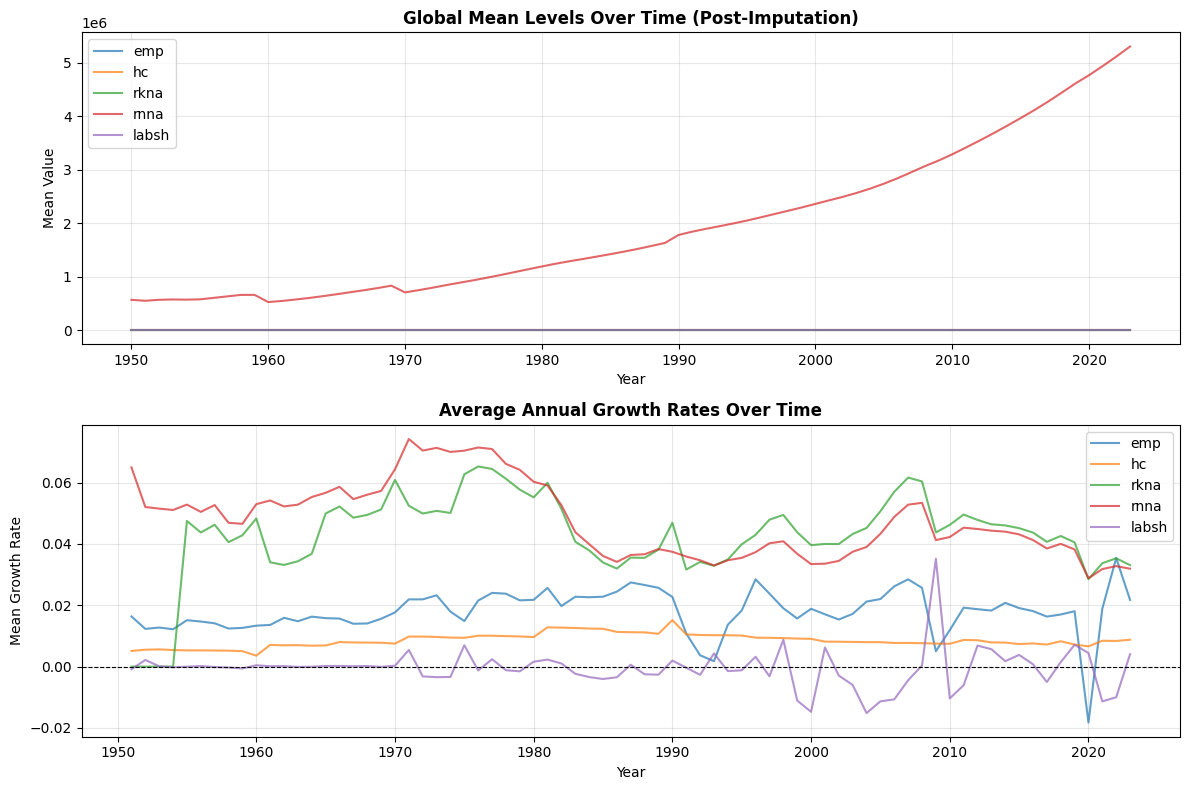


[OK] Validation complete


In [37]:
# Time trend visualization
print("\n6. TIME TRENDS")
print("-" * 60)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Panel 1: Levels
for var in vars_to_validate:
    df.groupby('year')[var].mean().plot(ax=axes[0], label=var, alpha=0.7)
axes[0].set_title("Global Mean Levels Over Time (Post-Imputation)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Mean Value")
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Panel 2: Growth rates
for var in vars_to_validate:
    df.groupby('year')[f'{var}_growth'].mean().plot(ax=axes[1], label=var, alpha=0.7)
axes[1].set_title("Average Annual Growth Rates Over Time", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Mean Growth Rate")
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

print("\n[OK] Validation complete")

## 8. Sanity Check

In [ ]:
# Sanity validation
cols = ['rgdpo','rnna','emp','hc','labsh','rtfpna']
print("Missing values check:")
print(df[cols].isna().mean())

# Growth accounting identity residuals
alpha = (1 - df['labsh']).clip(0.05, 0.95)
df['ga_error'] = (
    df.groupby('countrycode')['rgdpo'].pct_change()
    - (df.groupby('countrycode')['rtfpna'].pct_change()
       + alpha * df.groupby('countrycode')['rnna'].pct_change()
       + (1 - alpha) * (df.groupby('countrycode')['emp'].pct_change()
                        + df.groupby('countrycode')['hc'].pct_change()))
)
print(df['ga_error'].describe(percentiles=[.01,.05,.5,.95,.99]))

## 9. Export Imputed Dataset

In [1]:
# Remove temporary columns
df = df.drop(columns=['rkna_proxy', 'ky_ratio', 'kl_ratio'] + 
             [f'{v}_growth' for v in vars_to_validate], 
             errors='ignore')

# Save to CSV
output_path = 'dataset/pwt110_imputed.csv'
df.to_csv(output_path, index=False)
print(f"\n{'='*60}")
print(f"Dataset saved to: {output_path}")
print(f"  • Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  • Countries: {df['countrycode'].nunique()}")
print(f"  • Years: {df['year'].min()}-{df['year'].max()}")
print(f"{'='*60}")

NameError: name 'df' is not defined